In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

from DynamicalSystemLayer import *
from models import *
from utiils import train_model

In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np

# Real data : data preparation

In [4]:
data_path = '../data/'
data = pd.read_parquet(data_path+'SPY_hourly.parquet')

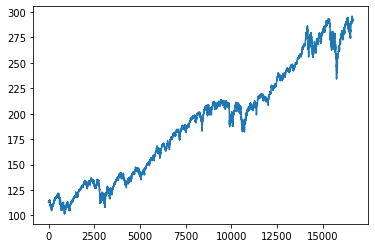

In [6]:
plt.plot(data.values)
plt.show()

In [7]:
data

,Price
timestamp,
2010-01-04 14:59:00,112.835
2010-01-04 15:59:00,113.105
2010-01-04 16:59:00,113.275
2010-01-04 17:59:00,113.325
2010-01-04 18:59:00,113.195
...,...
2019-06-28 15:59:00,292.545
2019-06-28 16:59:00,292.995
2019-06-28 17:59:00,292.555


In [5]:
price = data['Price']
price

timestamp
2010-01-04 14:59:00    112.835
2010-01-04 15:59:00    113.105
2010-01-04 16:59:00    113.275
2010-01-04 17:59:00    113.325
2010-01-04 18:59:00    113.195
                        ...   
2019-06-28 15:59:00    292.545
2019-06-28 16:59:00    292.995
2019-06-28 17:59:00    292.555
2019-06-28 18:59:00    292.335
2019-06-28 19:59:00    293.085
Name: Price, Length: 16649, dtype: float64

In [9]:
price.shape

(16649,)

In [6]:
price_stand = (price.values - price.values.mean())/price.values.std()

In [7]:
price_stand

array([-1.41977533, -1.41484644, -1.41174307, ...,  1.86103956,
        1.85702343,  1.87071479])

In [23]:
max(price_stand)

1.9210989937522152

In [24]:
min(price_stand)

-1.6267886895972874

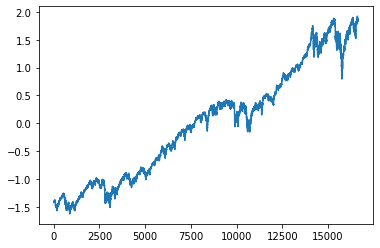

In [20]:
plt.plot(price_stand.values)
plt.show()

In [29]:
nan_detect = np.isnan(price_stand)

In [31]:
np.unique(nan_detect)

array([False])

In [37]:
price_stand

array([-1.41977533, -1.41484644, -1.41174307, ...,  1.86103956,
        1.85702343,  1.87071479])

In [73]:
def train_test_split(feature, ratio=0.8):
    train_size = int(len(feature)*ratio)
    train_set = feature[:train_size]
    test_set = feature[train_size:]
    return train_set, test_set

In [74]:
train_set, test_set = train_test_split(price_stand)

In [78]:
train_set[:-8].shape

(13311,)

In [79]:
test_set[:-9].shape

(3321,)

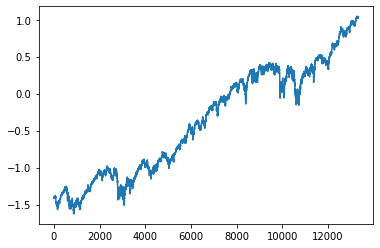

In [47]:
plt.plot(train_set[1:])
plt.show()

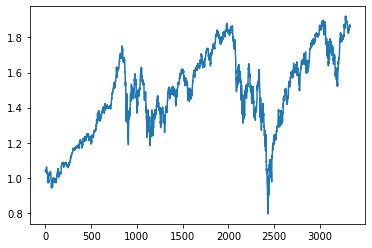

In [48]:
plt.plot(test_set[1:])
plt.show()

In [83]:
train_set = train_set[:-8]
test_set = test_set[:-9]

In [84]:
train_input = torch.FloatTensor(train_set[:-1]).unsqueeze(1)
train_target = torch.FloatTensor(train_set[1:]).unsqueeze(1)
test_input = torch.FloatTensor(test_set[:-1]).unsqueeze(1)
test_target = torch.FloatTensor(test_set[1:]).unsqueeze(1)

# Create the model

In [39]:
class NeuralNetODE(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, bias=False):
        super(NeuralNetODE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.bias = bias
        
        #layers
        self.fc1 = nn.Linear(in_features=self.in_dim, out_features=self.in_dim)
        self.ode = NNODEModel(self.in_dim, self.hid_dim, self.out_dim)
        self.fc2 = nn.Linear(in_features=self.out_dim, out_features=self.out_dim)
        
        
    def forward(self, x):
        out = self.fc1(x)
        out = self.ode(out)
        out = self.fc2(out)
        return out
    

In [88]:
def test_model(model, test_x, test_y, loss_fn, batch_size=1):
    test_loss = 0
    with torch.no_grad():
        for b in range(0, test_x.size(0), batch_size):
            pred = model(test_x.narrow(0, b, batch_size))
            loss = loss_fn(pred, test_y.narrow(0, b, batch_size))
            test_loss += loss.item()
        return test_loss, pred

In [92]:
input_dim = 1
model = NeuralNetODE(input_dim, input_dim, input_dim)

In [93]:
loss_fn = nn.MSELoss()
optimizer = optim.Adagrad(model.parameters(), lr=1e-2)
n_epoch = 1000
train_losses = []
test_losses = []

In [94]:
for epoch in range(n_epoch):
    model.train()
    train_loss,_ = train_model(model, train_input, train_target, loss_fn, optimizer, batch_size=10)
    train_losses.append(train_loss)
    model.eval()
    test_loss,_ = test_model(model, test_input, test_target, loss_fn, batch_size=10)
    test_losses.append(test_loss)
    if epoch%10 == 0:
        print('Epoch:', epoch+1, ', train_loss:', train_loss, ', test_loss:', test_loss)

Epoch: 1 , train_loss: 118.15543443291881 , test_loss: 2.2807590533047915
Epoch: 11 , train_loss: 0.12508780745201875 , test_loss: 0.08466431765521065
Epoch: 21 , train_loss: 0.1250711123873316 , test_loss: 0.08469327809882543
Epoch: 31 , train_loss: 0.1250710262784196 , test_loss: 0.08469355427610026
Epoch: 41 , train_loss: 0.12507092912096596 , test_loss: 0.08469373853984052
Epoch: 51 , train_loss: 0.12507076268502715 , test_loss: 0.08469368761279839
Epoch: 61 , train_loss: 0.12507069866751408 , test_loss: 0.08469344462878325
Epoch: 71 , train_loss: 0.12507066373336784 , test_loss: 0.08469358137665495
Epoch: 81 , train_loss: 0.12507051233910715 , test_loss: 0.08469344876868945
Epoch: 91 , train_loss: 0.1250704777107785 , test_loss: 0.08469375308220606
Epoch: 101 , train_loss: 0.12507033919428068 , test_loss: 0.08469350752318405
Epoch: 111 , train_loss: 0.12507022839986348 , test_loss: 0.08469362213782006
Epoch: 121 , train_loss: 0.12507011015668468 , test_loss: 0.0846938027939359
Epo

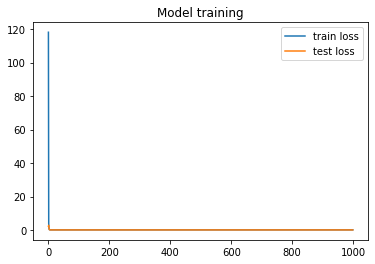

In [95]:
plt.figure()
plt.plot(train_losses, label='train loss');
plt.plot(test_losses, label='test loss')
plt.title('Model training')
plt.legend()
plt.show()

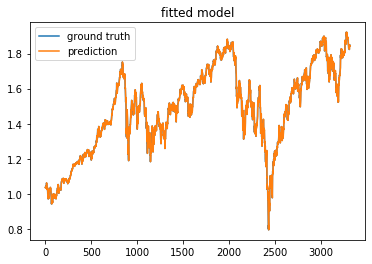

In [98]:
prediction = model(test_input)
plt.figure()
plt.plot(test_target.numpy(), label='ground truth');
plt.plot(prediction.detach().numpy(), label='prediction')
plt.title('fitted model')
plt.legend()
plt.show()